In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


## Step 1 Data exploration

for a general regression process and up until training the best model i created this outline and i want you to refine it for me and tell me the best process.

1. do data expolration by using ( info,dtypes,describe,value counts, head, tail, )
2. check data distribution by visulaizations (example: target distribution( does it need log transformation or not),distribution of other features and variables, correlation matrix visulaizations for all features to eachother ,)
3. drop unneccessary columns using df.drop
4. do fetaure selection , using eithe rfe or rfecv or other methods do a selection of the best features 
5. do feature engineering ,combine the train and test datasets make new features from existing features by doing sometype of operaion on them.
6. do imputations or missing value handling (separately for both numerical and categorical features and if missing nor at random make a placeholder)
7. now in a pipeline create column transformers and column selectors to select the columns that we want and then do scaling-for numerical features, encoding for categoraical features.,
8. do PCA and dimensionality reduction still in the pipeline
9. in the pipeline fit the data to multiple regression models with names.
10. use some kind of regression metrics to compare the output of the models
11. take the model that gave you the best results and do either grid search cv or randomised search cv on it to get the best parameters for it.
12.  using the best model with the best parameters do a kfold crossvalidation on it to get the accurate average metric of it. and do different cross validation plots.like learning curve and validation curve.
13. finally export the model with joblib. 
14. using my test data i could also do pridiction 

this are my steps but i am not sure if i missed any thing on if the order of some of them is not correct so please carefully review it and give me what you think would be an accurate general outline for regression. somethings i fill uneasy about is all the transformations i made into my train data when will i apply them to my test data, is the cross validation placed at a the right step, should i do grid search cv only for the model that got the best score only on initial traiing or should i also do for all of them , should i do feature selection before feature engineering, did i use pca at the right step ...and things like that.
 
 and give me detailed response with good recommendations of what to do inside each step for example inside data visauliizations step  you can reccommend me many different visuallizations like correlation matrix and etc...


Nice work — your outline already has the right pieces. I’ll refine it into a **clean, battle-tested end-to-end process for regression**, explain *why* each step goes where, and give concrete recommendations for what to do inside each step (visualizations, choices, how to avoid leakage, where to put PCA/feature selection, CV strategy, etc.). I’ll also answer your exact questions (when to apply transforms to test, order of selection vs engineering, gridsearch strategy, etc.).

---

## High-level summary (one-line)

1. **Problem & metric** → 2. **EDA & visual diagnosis** → 3. **Hold-out split (or define CV / test set)** → 4. **Feature engineering (training-safe)** → 5. **Build ColumnTransformer + Pipeline (impute/encode/scale/featgen/selection/PCA)** → 6. **Baseline models with CV** → 7. **Select top models → hyperparameter search (inside pipeline)** → 8. **Final evaluation on hold-out test (or outer CV)** → 9. **Diagnostics & interpretation** → 10. **Save model & deploy**.

Everything that learns parameters from data must be **fitted only on training folds** (use pipelines / ColumnTransformer). Never fit preprocessing on test/validation.

---

## Refined step-by-step process (detailed)

### 0) Define problem & success criteria (very first)

* Target, required metric(s) (RMSE / MAE / R² / business metric), latency, interpretability constraints.
* Decide final evaluation: single hold-out test set or nested CV for research-quality estimate.

---

### 1) Exploratory Data Analysis (EDA) — *do this before modeling but do not leak target info into preprocessing*

Useful commands: `df.info()`, `df.dtypes`, `df.describe()`, `df.head()`, `df.tail()`, `df.nunique()`, `.isna().sum()`

**Visualizations & checks**

* **Target distribution**: histogram, KDE → check skew → consider `log1p` if long tail.
* **Feature distributions**: histograms / KDEs for numerics; boxplots for outliers.
* **Categorical counts**: barplots for top categories; look at high cardinality features.
* **Pairwise relationships / scatterplots**: target vs key features.
* **Correlation matrix / heatmap**: numeric feature correlations and with target.
* **Missingness matrix**: heatmap / `missingno` to find patterns (MCAR vs MNAR).
* **Outliers**: boxplots / IQR checks.
* **Group checks**: if repeated measures (user, region), inspect group sizes and leakage risk.
* **Simple feature vs target plots**: partial dependence style scatter/LOESS.

**When you do EDA on full data vs train:** EDA is ok on full raw data for understanding, but avoid using the full-target statistics to set preprocessing that will be “fitted” (e.g., don’t use test mean to impute unless you’re going to implement that logic via pipeline fitted on train only).

---

### 2) Create hold-out test set (and possibly validation split)

**Why:** to get an honest final estimate.

* Option A: `train_test_split` 70/30 or 80/20 (stratify if needed).
* Option B: If small data or you want robust estimate, plan **nested CV**: outer loop for final estimate, inner loop for hyperparameter tuning.
  **Rule:** after splitting, only use the training set for fitting pipelines and CV. The hold-out test is untouched until the final evaluation.

---

### 3) Feature engineering — *do this before hyperparameter tuning but implemented as transformers in pipeline when possible*

**What to do here:**

* Extract date parts (year, month, day, weekday) from datetime.
* Create interaction or ratio features (rooms_per_household, price_per_area).
* Binning (KBins) if meaningful (but beware losing information).
* Domain-driven transforms (e.g., convert quality labels to ordinal).
* Create flags for missingness (MissingIndicator) **inside pipeline** or explicitly add `MissingIndicator` transformer.
* **Target-derived features (leakage risk)** — do NOT create features that use future or global target info. If you must create target-based stats (e.g., target mean by group), use **target encoding** with careful nested CV or smoothing and implement it *inside* pipeline with proper CV-safe encoders.

**Important:** Prefer implementing engineered features as transformers (custom `TransformerMixin`) so they can be fit/transform inside the pipeline and be applied consistently to validation/test data.

---

### 4) Decide preprocessing strategies & build ColumnTransformer pipelines

This is the critical part that prevents leakage.

**Split features by type:**

* numeric_cols, categorical_cols, text_cols, date_cols, high_cardinality_cols, id_cols (drop)

**Numeric pipeline (example)**

* Imputer: `SimpleImputer(strategy='median')` (or `KNNImputer` inside nested numeric pipeline if appropriate)
* Optional: outlier handling (capping, log transform via `FunctionTransformer`)
* Scaler: `StandardScaler()` if required for model (linear/SVR/NN). If using trees, scaling not necessary.

**Categorical pipeline**

* Impute: `SimpleImputer(strategy='constant', fill_value='MISSING')`
* Encoding: `OneHotEncoder(handle_unknown='ignore', sparse_output=False)` for low-cardinality; for high-cardinality use `TargetEncoder` (from category_encoders) or `HashingEncoder` carefully within CV.

**Text pipeline**

* `TfidfVectorizer` or `HashingVectorizer`, possibly followed by TruncatedSVD.

**Combine via `ColumnTransformer`** (numeric, categorical, text).

**FeatureUnion**: use when you want parallel representations of the same data (e.g., original features + PCA features + polynomial features). Remember FeatureUnion concatenates outputs.

---

### 5) Feature selection & dimensionality reduction — **inside the pipeline**

**Place them inside the pipeline after preprocessing** (after scaling and encoding), because selection must be learned only on training folds during CV.

Order suggestions:

* Preprocess → (optional) Feature generation / FeatureUnion → (optional) `SelectKBest` or `SelectFromModel` or `RFE` → (optional) `PCA`/`TruncatedSVD` → model.

**When to use PCA:**

* Use PCA/TruncatedSVD when you need to reduce dimensionality (many features, multicollinearity) or before models sensitive to multicollinearity. Put **PCA after scaling** and after encoding (if dense). For sparse TF-IDF use **TruncatedSVD**.
* If interpretability is required, avoid PCA or keep both original + PCA features (but interpretability reduces).

**Feature selection vs engineering order:**

* **Engineer features first** (you create new candidate features).
* **Then select** (RFE, SelectKBest, RFECV) inside pipeline.
* Rationale: selection should consider engineered features.

---

### 6) Baseline models & cross-validated evaluation

**Baseline:** always start with simple baselines — mean predictor, linear regression, and one tree model.

**Use CV properly:**

* Use `cross_validate` / `cross_val_score` with your pipeline (preprocessing+selection+model inside).
* Use appropriate CV splitter: `KFold` for regression, `GroupKFold` if grouped data, `TimeSeriesSplit` if time-dependent.

**Compare models:** evaluate CV mean and std for metrics (RMSE, MAE, R²). Use `cross_val_predict` when you need out-of-fold predictions for diagnostics (residuals, calibration).

**Nested CV (recommended)** if you will compare many model types and hyperparameter tuning results — avoids optimistic bias from tuning on same CV used to pick model. Procedure:

* Outer loop: estimate generalization (e.g., 5 folds)
* Inner loop: hyperparameter tuning via Grid/Randomized CV

---

### 7) Model selection & hyperparameter tuning

**Strategy:**

* Do a **light search** (RandomizedSearchCV) across *several* candidate models to shortlist (e.g., RandomForest, LightGBM, Ridge, SVR).
* For the top 1–3 models, run more thorough `GridSearchCV` or `RandomizedSearchCV` with more iterations and more folds.
* Always keep preprocessing inside the pipeline and tune pipeline steps (e.g., `preproc__num__impute__strategy`, `select__k`, `model__n_estimators`).

**Important**: tune using CV on training data only. Use `n_jobs=-1` to speed up.

**Should you gridsearch all models or only best initial?**

* Practical approach: **coarse search across many models**, then **refined search** on the best few. Doing exhaustive gridsearch for every model is usually time-consuming and unnecessary.

---

### 8) Final evaluation — test set or outer CV

* After tuning, evaluate your final chosen single pipeline on the **hold-out test set** one time (or use outer fold in nested CV).
* Report metrics, confidence intervals (via repeated CV), and diagnostic plots (residuals, predicted vs actual, feature importance).

---

### 9) Diagnostics & interpretability

* Residual plots (hist, residual vs prediction).
* Error by segment (deciles of predictions, groups).
* Permutation importance (works for any model) — less biased than tree importances.
* Partial dependence plots or SHAP for detailed interpretation.

If model shows overfitting or strange errors, return to steps: feature engineering, simplify model, regularize, collect more data.

---

### 10) Save model & deployment

* Save the **entire fitted pipeline** with `joblib.dump(pipeline, "model.joblib")`. The pipeline includes preprocessing so you can call `.predict()` on raw rows.
* For production, wrap input validation (schema checks) and apply the pipeline directly.

---

## Answering your specific questions

### Q: *"When will I apply all the transformations I made into my train data to test data?"*

**Answer:** Never fit preprocessors on test data. Fit (train) on training set only. Use the fitted pipeline to `.transform()` the test set. If you put all transformations in a `Pipeline` or `ColumnTransformer`, calling `pipeline.fit(X_train, y_train)` and later `pipeline.predict(X_test)` will apply exactly the same transformations to test — no leakage.

### Q: *"Is cross validation placed at the right step?"*

**Answer:** CV is used during model evaluation and hyperparameter tuning. Use CV (inside `cross_val_score`) to compare baseline models. Use CV inside `GridSearchCV`/`RandomizedSearchCV` for tuning. If you're also selecting which model family to use, consider **nested CV** to avoid selection bias.

### Q: *"Should I do grid search CV only for the model that got the best score or for all of them?"*

**Answer:** Do a **coarse search across several models**. Then do more expensive tuning on the top 1–3 candidates. That’s computationally efficient and effective in practice.

### Q: *"Should I do feature selection before feature engineering?"*

**Answer:** **Feature engineering first**, then **selection**. Rationale: you want selection to consider engineered features. But selection must be done inside the pipeline (fitted only on the training fold) to avoid leakage.

### Q: *"Did I use PCA at the right step?"*

**Answer:** PCA (or TruncatedSVD) should be **after scaling and encoding** and **inside the pipeline**. Decide whether you use PCA as a feature reduction step (replace originals) or as a generator (FeatureUnion to keep both original + PCA components). PCA reduces interpretability — use it mainly for dimensionality reduction or to de-correlate features for linear models.

---

## Recommended visualizations and diagnostics (detailed)

* **Distribution plots**: `sns.histplot()`, `sns.kdeplot()` for target & numeric features.
* **Boxplots**: detect outliers (`sns.boxplot()`).
* **Scatter**: `sns.scatterplot()` for target vs feature.
* **Pairplot**: `sns.pairplot()` for small feature sets.
* **Correlation heatmap**: `sns.heatmap(df.corr(), annot=True)` to see multicollinearity.
* **Missingness plot**: `missingno.matrix()` / `heatmap` of `isna()` to visualize missing patterns.
* **Category counts**: barplots for categorical columns (`value_counts().head()`).
* **Predicted vs Actual**: scatter with `y=x` line.
* **Residual histogram and Residual vs Predicted**.
* **Learning curve**: `sklearn.model_selection.learning_curve()` to diagnose bias/variance.
* **Validation curve**: `validation_curve()` to see hyperparameter impact.
* **Permutation importance plot**: `sklearn.inspection.permutation_importance`.
* **Partial dependence / ICE plots**: `sklearn.inspection.plot_partial_dependence` or SHAP plots.

---

## Practical code skeleton (pseudocode showing correct placement)

```python
# 1. split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. define pipelines
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preproc = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

# 3. full pipeline with selection + model
pipe = Pipeline([
    ("preproc", preproc),
    ("feat_sel", SelectFromModel(RandomForestRegressor(n_estimators=100))),
    ("pca", PCA(n_components=20)),          # optional
    ("model", RandomForestRegressor())
])

# 4. baseline CV
scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=("r2","neg_root_mean_squared_error"))

# 5. randomized search on top models
param_dist = {...}
search = RandomizedSearchCV(pipe, param_distributions=param_dist, cv=5, n_iter=50)
search.fit(X_train, y_train)

# 6. final eval on hold-out
best = search.best_estimator_
y_pred = best.predict(X_test)
print(r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False))

# 7. save pipeline
joblib.dump(best, "final_pipeline.joblib")
```

---

## Final checklist you can copy-paste

1. Define problem & metric.
2. EDA + visualizations.
3. Create hold-out test set (keep untouched).
4. Feature engineering (write transformers).
5. Create ColumnTransformer & Pipelines (impute/encode/scale/featgen).
6. Plug selection / PCA inside pipeline (after preprocessing).
7. Baseline CV on several models.
8. Coarse hyperparameter search across models → shortlist.
9. Refined hyperparameter search on top candidates (nested CV if possible).
10. Final evaluation on hold-out test; produce diagnostics.
11. Interpret features, compute SHAP/permutation importance.
12. Save the final fitted pipeline.
13. Write deployment wrapper & monitoring plan.

---

If you want, I can now:

* Take your original outline and rewrite it into a **clean checklist** you can save/print.
* Or I can produce a **notebook template** (code) implementing the refined process for a dataset you pick. Which would help more right now?


In [3]:
"""# ===============================================
# 🚀 House Price Prediction - Full Pipeline Script
# ===============================================

# === Import Dependencies ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ===============================================
# 🚀 1. Load Dataset
# ===============================================
df = pd.read_csv("house_prices.csv")  # update this path

print("\nInitial Dataset Info\n")
print(df.info())
print(df.head())

# ===============================================
# 🚀 2. Basic Exploration
# ===============================================
print("\nMissing Values Summary\n")
print(df.isnull().sum())

# visualize target distribution
plt.figure(figsize=(6, 4))
sns.histplot(df["SalePrice"], kde=True)
plt.title("Distribution of Sale Price")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ===============================================
# 🚀 3. Train-Test Split
# ===============================================
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain Shape: {X_train.shape}   Test Shape: {X_test.shape}")

# ===============================================
# 🚀 4. Identify Numerical & Categorical Columns
# ===============================================
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

print("\nNumerical Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

# ===============================================
# 🚀 5. Build Preprocessing Transformers
# ===============================================
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

# ===============================================
# 🚀 6. Train Models and Evaluate with CV
# ===============================================
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GBM": GradientBoostingRegressor(random_state=42)
}

print("\nCross-validation Model Scores (RMSE):")
cv_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(pipe, X_train, y_train,
                             scoring="neg_root_mean_squared_error", cv=cv)

    cv_results[name] = np.mean(scores)

    print(f"{name}: {-np.mean(scores):.4f}")  # convert to positive RMSE

# Pick best
best_model_name = min(cv_results, key=cv_results.get)
print(f"\nBest Model from CV: {best_model_name}")

# ===============================================
# 🚀 7. Hyperparameter Tuning for Best Model
# ===============================================
pipe_gbm = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

param_grid = {
    "model__n_estimators": [100, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
}

grid = GridSearchCV(
    estimator=pipe_gbm,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

print("\nRunning Hyperparameter Tuning...\n")
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("\nBest Hyperparameters:")
print(grid.best_params_)

# ===============================================
# 🚀 8. Final Evaluation
# ===============================================
y_pred = best_model.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred)**0.5
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

print("\nFinal Test Evaluation:")
print(f"RMSE: {RMSE:.4f}")
print(f"MAE: {MAE:.4f}")
print(f"R2 Score: {R2:.4f}")

# ===============================================
# 🚀 9. Save Final Model
# ===============================================
joblib.dump(best_model, "house_price_model.pkl")
print("\nModel saved successfully as 'house_price_model.pkl'")"""


'# ===============================================\n# 🚀 House Price Prediction - Full Pipeline Script\n# ===============================================\n\n# === Import Dependencies ===\nimport pandas as pd\nimport numpy as np\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\nfrom sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\n\nfrom sklearn.linear_model import LinearRegression, Ridge, Lasso\nfrom sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor\n\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport joblib\n\n# ===============================================\n# 🚀 1. Load Dataset\n# ===============================================\ndf = pd.read_csv("house_prices.csv")  # update this path\n\npr

In [2]:
"""
========================================================
House Price Prediction - End to End Regression Workflow
Author: Nahum
========================================================


# ===============================
# 1. IMPORTS
# ===============================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import joblib



# ===============================
# 2. CONFIG / GLOBAL CONSTANTS
# ===============================
RANDOM_STATE = 42
TARGET = 'price'
MODEL_SAVE_PATH = "models/best_model.joblib"





# ===============================
# 3. HELPER FUNCTIONS
# ===============================

def load_data(train_path, test_path=None):
    #Loads train and test dataset from disk.
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path) if test_path else None
    return train_df, test_df


def preprocess(df):
    #Basic column filtering and NA removal logic.
    df = df.drop_duplicates()

    # Remove useless columns for example (customize)
    drop_list = ['id', 'street_name'] if 'street_name' in df.columns else ['id']
    df = df.drop(columns=[col for col in drop_list if col in df.columns], errors='ignore')
    return df


def split_features_target(df):
    #Split X and y based on TARGET variable.
    X = df.drop(columns=[TARGET])
    y = df[TARGET]
    return X, y



def build_preprocessor(X):
    #Builds transformers based on column types

    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    numeric_pipeline = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ])

    return preprocessor




def build_models_and_pipelines(preprocessor):
    # Return dictionary of candidate models

    models = {
        "lr": LinearRegression(),
        "ridge": Ridge(alpha=2),
        "rf": RandomForestRegressor(n_estimators=150, random_state=RANDOM_STATE)
    }

    pipelines = {}
    for name, model in models.items():
        pipelines[name] = Pipeline([
            ("prep", preprocessor),
            ("reduce_dim", PCA(n_components=10)),  # optional
            ("model", model)
        ])

    return pipelines



def evaluate_models(pipelines, X_train, y_train):
    # Cross-validate all pipelines and return performance dict

    results = {}

    for name, pipe in pipelines.items():
        scores = cross_val_score(pipe, X_train, y_train,
                                 cv=5, scoring="neg_mean_squared_error")
        rmse_scores = np.sqrt(-scores)
        results[name] = rmse_scores.mean()

        print(f"{name} RMSE: {rmse_scores.mean():.4f}")

    return results



def get_best_model(results_dict, pipelines):
    # Returns pipeline with lowest RMSE 

    best_model_name = min(results_dict, key=results_dict.get)
    print(f"\nBEST MODEL SELECTED => {best_model_name}")

    return pipelines[best_model_name]




# ===============================
# 4. MAIN EXECUTION
# ===============================

def main():

    print("==== LOAD DATA ====")
    train_df, _ = load_data("data/train.csv", None)

    print("==== CLEAN DATA ====")
    train_df = preprocess(train_df)

    print("==== SPLIT FEATURES ====")
    X, y = split_features_target(train_df)

    print("==== PREPROCESS PIPELINE ====")
    preprocessor = build_preprocessor(X)

    print("==== MODEL PIPELINES ====")
    pipelines = build_models_and_pipelines(preprocessor)

    print("==== EVALUATE MODELS ====")
    results = evaluate_models(pipelines, X, y)

    print("==== GET BEST MODEL ====")
    best_pipe = get_best_model(results, pipelines)

    print("==== TRAIN BEST MODEL ====")
    best_pipe.fit(X, y)

    print("==== SAVE MODEL ====")
    joblib.dump(best_pipe, MODEL_SAVE_PATH)

    print("\nPipeline completed successfully!")




if __name__ == "__main__":
    main()"""


'\n========================================================\nHouse Price Prediction - End to End Regression Workflow\nAuthor: Nahum\n========================================================\n\n\n# ===============================\n# 1. IMPORTS\n# ===============================\n\nimport numpy as np\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split, KFold, cross_val_score\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.linear_model import LinearRegression, Ridge\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.decomposition import PCA\nimport joblib\n\n\n\n# ===============================\n# 2. CONFIG / GLOBAL CONSTANTS\n# ===============================\nRANDOM_STATE = 42\nTARGET = \'price\'\nMODEL_SAVE_PATH = "models/best_model.joblib"\n\n\n\n\

Glance at the head

In [7]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The bottom of the training data at a glance

In [8]:
df_train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [ ]:
df_test.isnull().sum().sort_values(ascending=False)[df_test.isnull().sum()>0]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageFinish      78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Exterior2nd        1
dtype: int64

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [13]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [15]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [16]:
df_train.nunique()

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 81, dtype: int64

## Initial Visualizations

### Target Distribution Visualizations

<Axes: xlabel='SalePrice', ylabel='Count'>

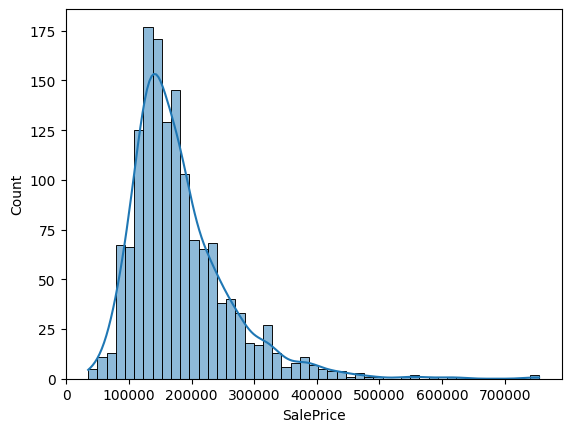

In [17]:
sns.histplot(data=df_train,x=df_train["SalePrice"],kde=True)

Most houses are priced at between 100,000 and 300,000 

### Numerical Features Distribution Visualizations

In [32]:
probable_numerical_features=df_train.select_dtypes(include=np.number).columns.to_list()

In [33]:
probable_numerical_features

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

Here in the numerical columns there are 3 types

1. continous variable which is rightfully continous and numerical
2. catagorical items presented as numerical example 'MSSubClass',"overallcond","overallQual" and their relationship is ordinal 1=Excellent better than 2=Very Good 

    also there are these items 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', that are discrete so not continous
    
3. Year info, which doesnt make sense as numbers, so has to be feature engineered to change to continous variable

#### 1. Continous variables

In [34]:
#rather than doing it manually one approch is to use treshold-value for uniqueness / cardinality
# and use the items with large uniqueness values as continous variables, columns that dont contain the word year
def identify_probable_continous(threshold,list_of_numerical_features):
    probable_continous=[]
    for feature in list_of_numerical_features:
        if df_train[feature].nunique()>threshold and "Year" not in feature:
            probable_continous.append(feature)
    return probable_continous

In [35]:
probable_continous=identify_probable_continous(threshold=20,list_of_numerical_features=probable_numerical_features)

In [36]:
probable_continous

['Id',
 'LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'MiscVal',
 'SalePrice']

Now we have a better list of features but we will further inspect them manually   
After manual inspection except ID ,'GarageYrBlt' and Sale Price the other are good to go as continous

In [54]:
continous_num_features=['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
'1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch','MiscVal',
]

lets Visualise the continous numerical features distribution

In [56]:
def continous_features_distribution_subplots(list_of_features,n_column):
    num_features=len(list_of_features)
    
    n_rows=int(np.ceil(num_features/n_column))  #ensures you have enough vertical space for every plot.
    fig, axes = plt.subplots(n_rows, n_column, figsize=(15, 5 * n_rows))

    axes = axes.flatten()# Flatten the axes array if 2d matrix or n_rows and cols came up

    for i,feature in enumerate(list_of_features):
        sns.histplot(data=df_train,x=feature,kde=True,ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}', fontsize=12)
        axes[i].set_xlabel(feature, fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
        
    # If the number of features is less than the total number of subplots (n_rows * n_cols)
    for j in range(num_features, n_rows * n_column):
        fig.delaxes(axes[j]) # delete axis

    #Add a main title and adjust layout
    # 'tight_layout' automatically adjusts subplot parameters for a tight layout
    fig.suptitle('Histograms for Continuous Numerical Features', fontsize=16, y=1.02)
    plt.tight_layout()

    #Display the final combined plot
    plt.show()

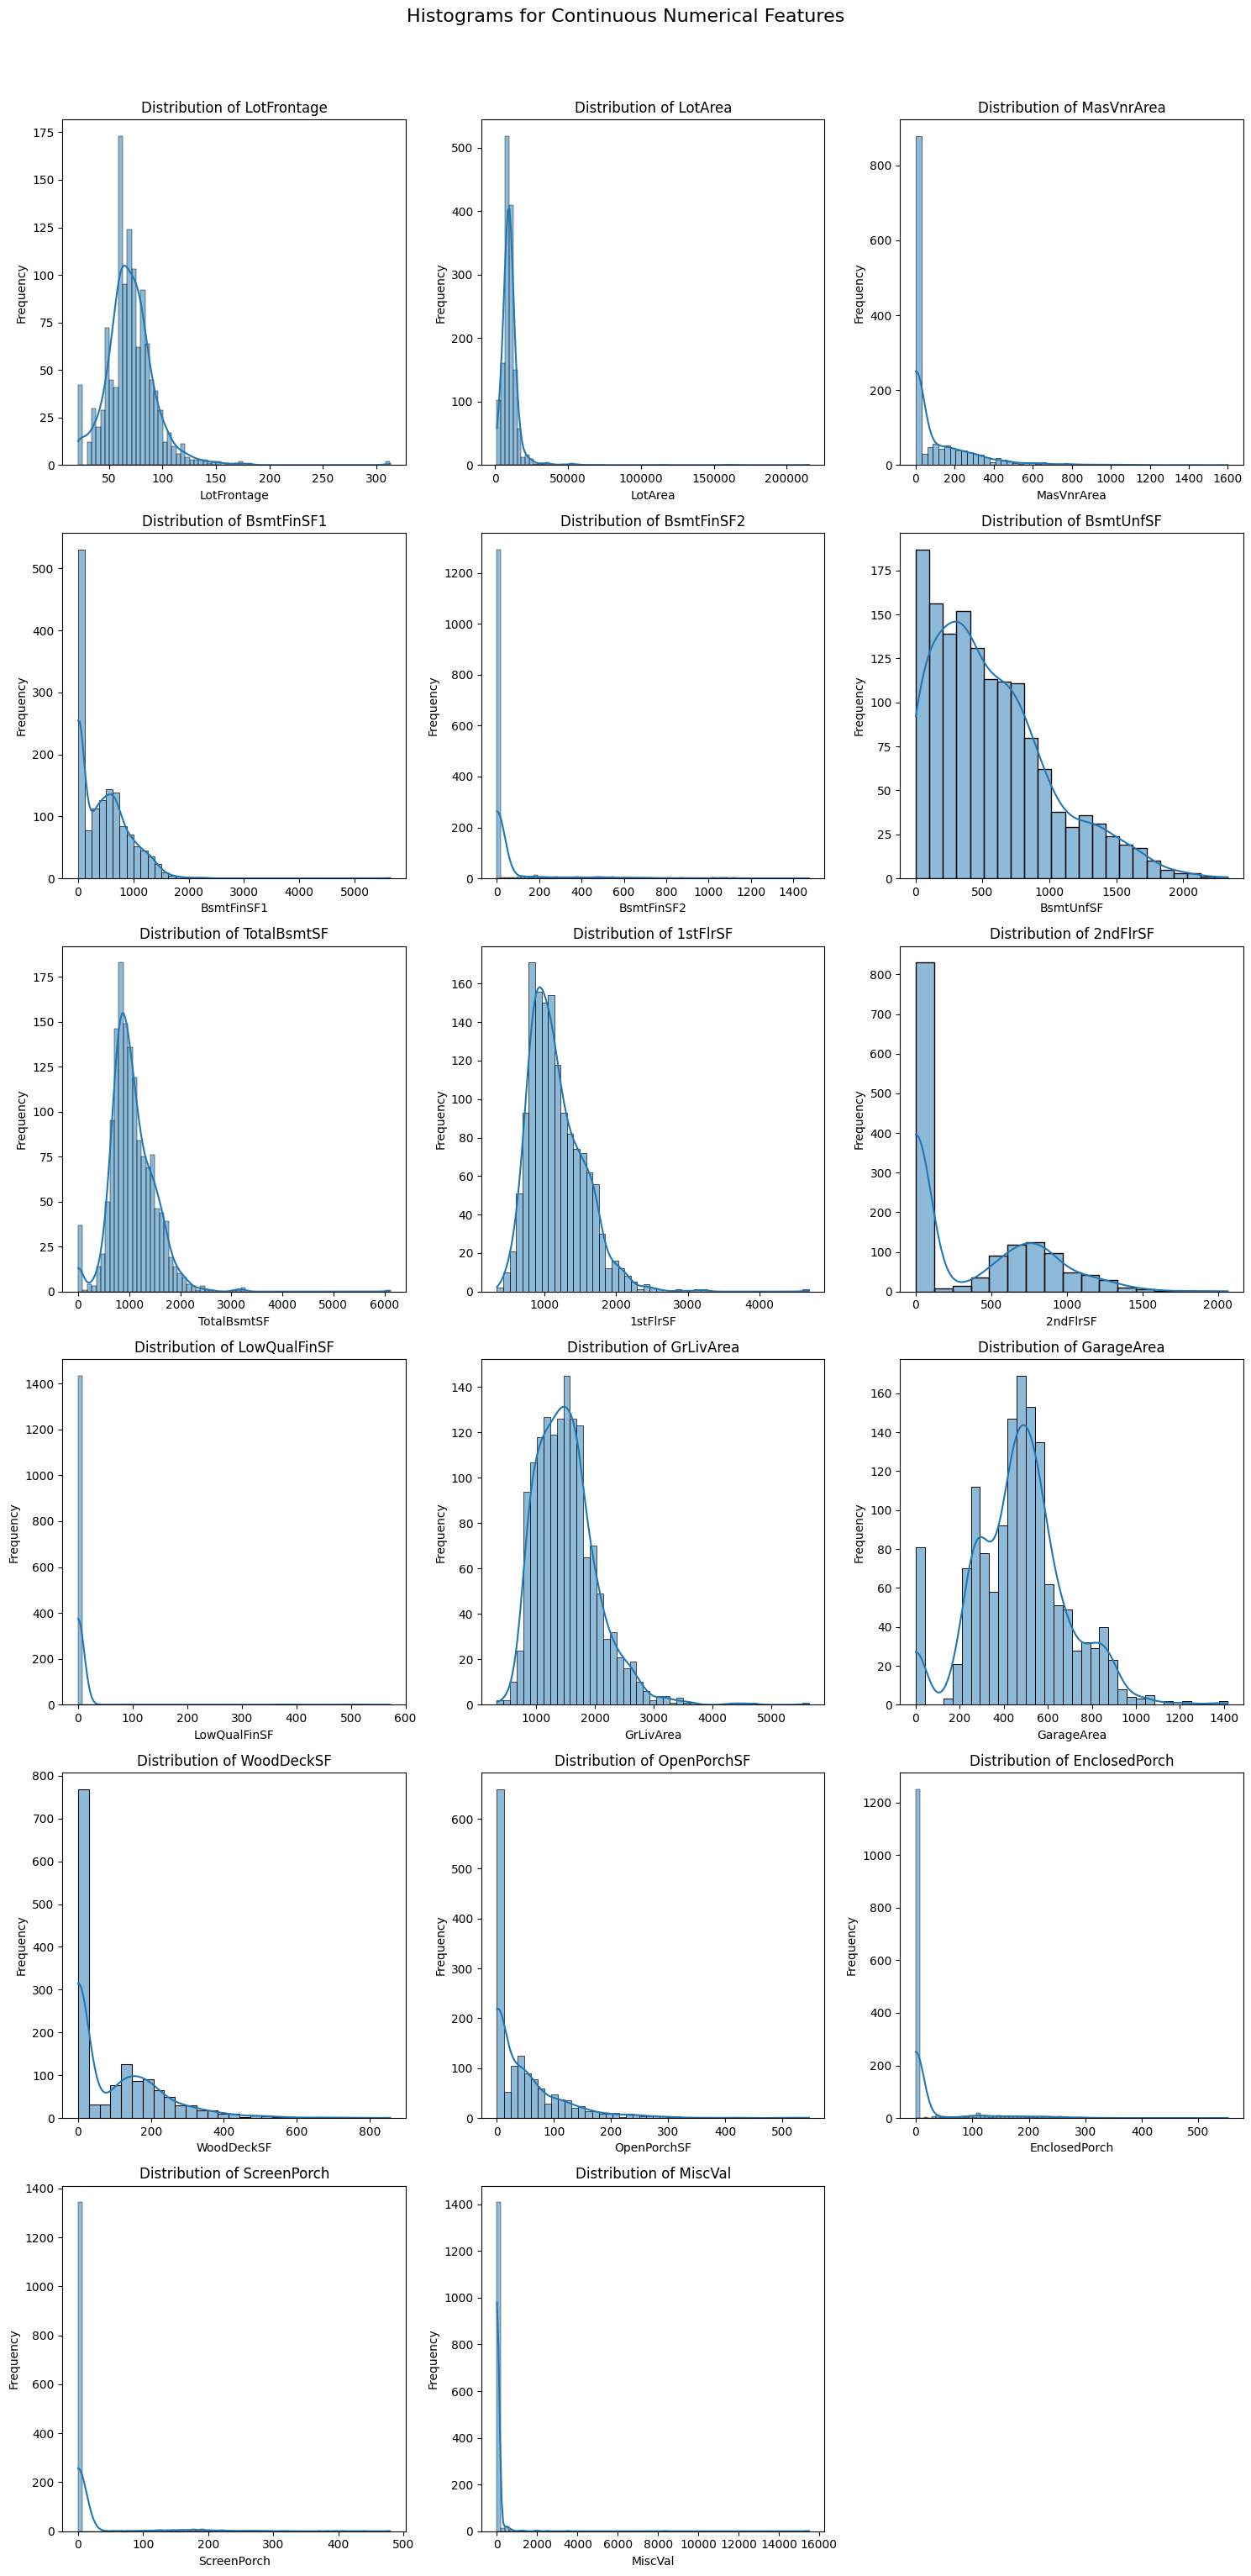

In [87]:
continous_features_distribution_subplots(continous_num_features,3)

#### Categorical Count / Cardinality checking visualization

In [59]:
categorical_features=df_train.select_dtypes(include="object").columns.to_list()

In [63]:
categorical_features

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [95]:
def categorical_feature_cardinality_subplot(list_of_features,n_column):
    
    num_features=len(list_of_features)
    n_rows=int(np.ceil(num_features/n_column))
    fig, axes = plt.subplots(n_rows, n_column, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i,c_feature in enumerate(list_of_features):
        value_counts=df_train[c_feature].value_counts()
        sns.barplot(x=value_counts.index,y=value_counts.values,ax=axes[i],palette="viridis")
        axes[i].set_title(f'Cardinality of {c_feature}', fontsize=12)
        axes[i].set_xlabel(c_feature, fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)

    for j in range(num_features,n_rows*n_column):
        fig.delaxes(axes[j]) # delete axis

    fig.suptitle('Histograms for Categorical Numerical Features', fontsize=16, y=1.02)
    plt.tight_layout()

    #Display the final combined plot
    plt.show()
    

C:\Users\lenovo T460s\AppData\Local\Temp\ipykernel_11412\2895428746.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index,y=value_counts.values,ax=axes[i],palette="viridis")
C:\Users\lenovo T460s\AppData\Local\Temp\ipykernel_11412\2895428746.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index,y=value_counts.values,ax=axes[i],palette="viridis")
C:\Users\lenovo T460s\AppData\Local\Temp\ipykernel_11412\2895428746.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index,y=value_counts.va

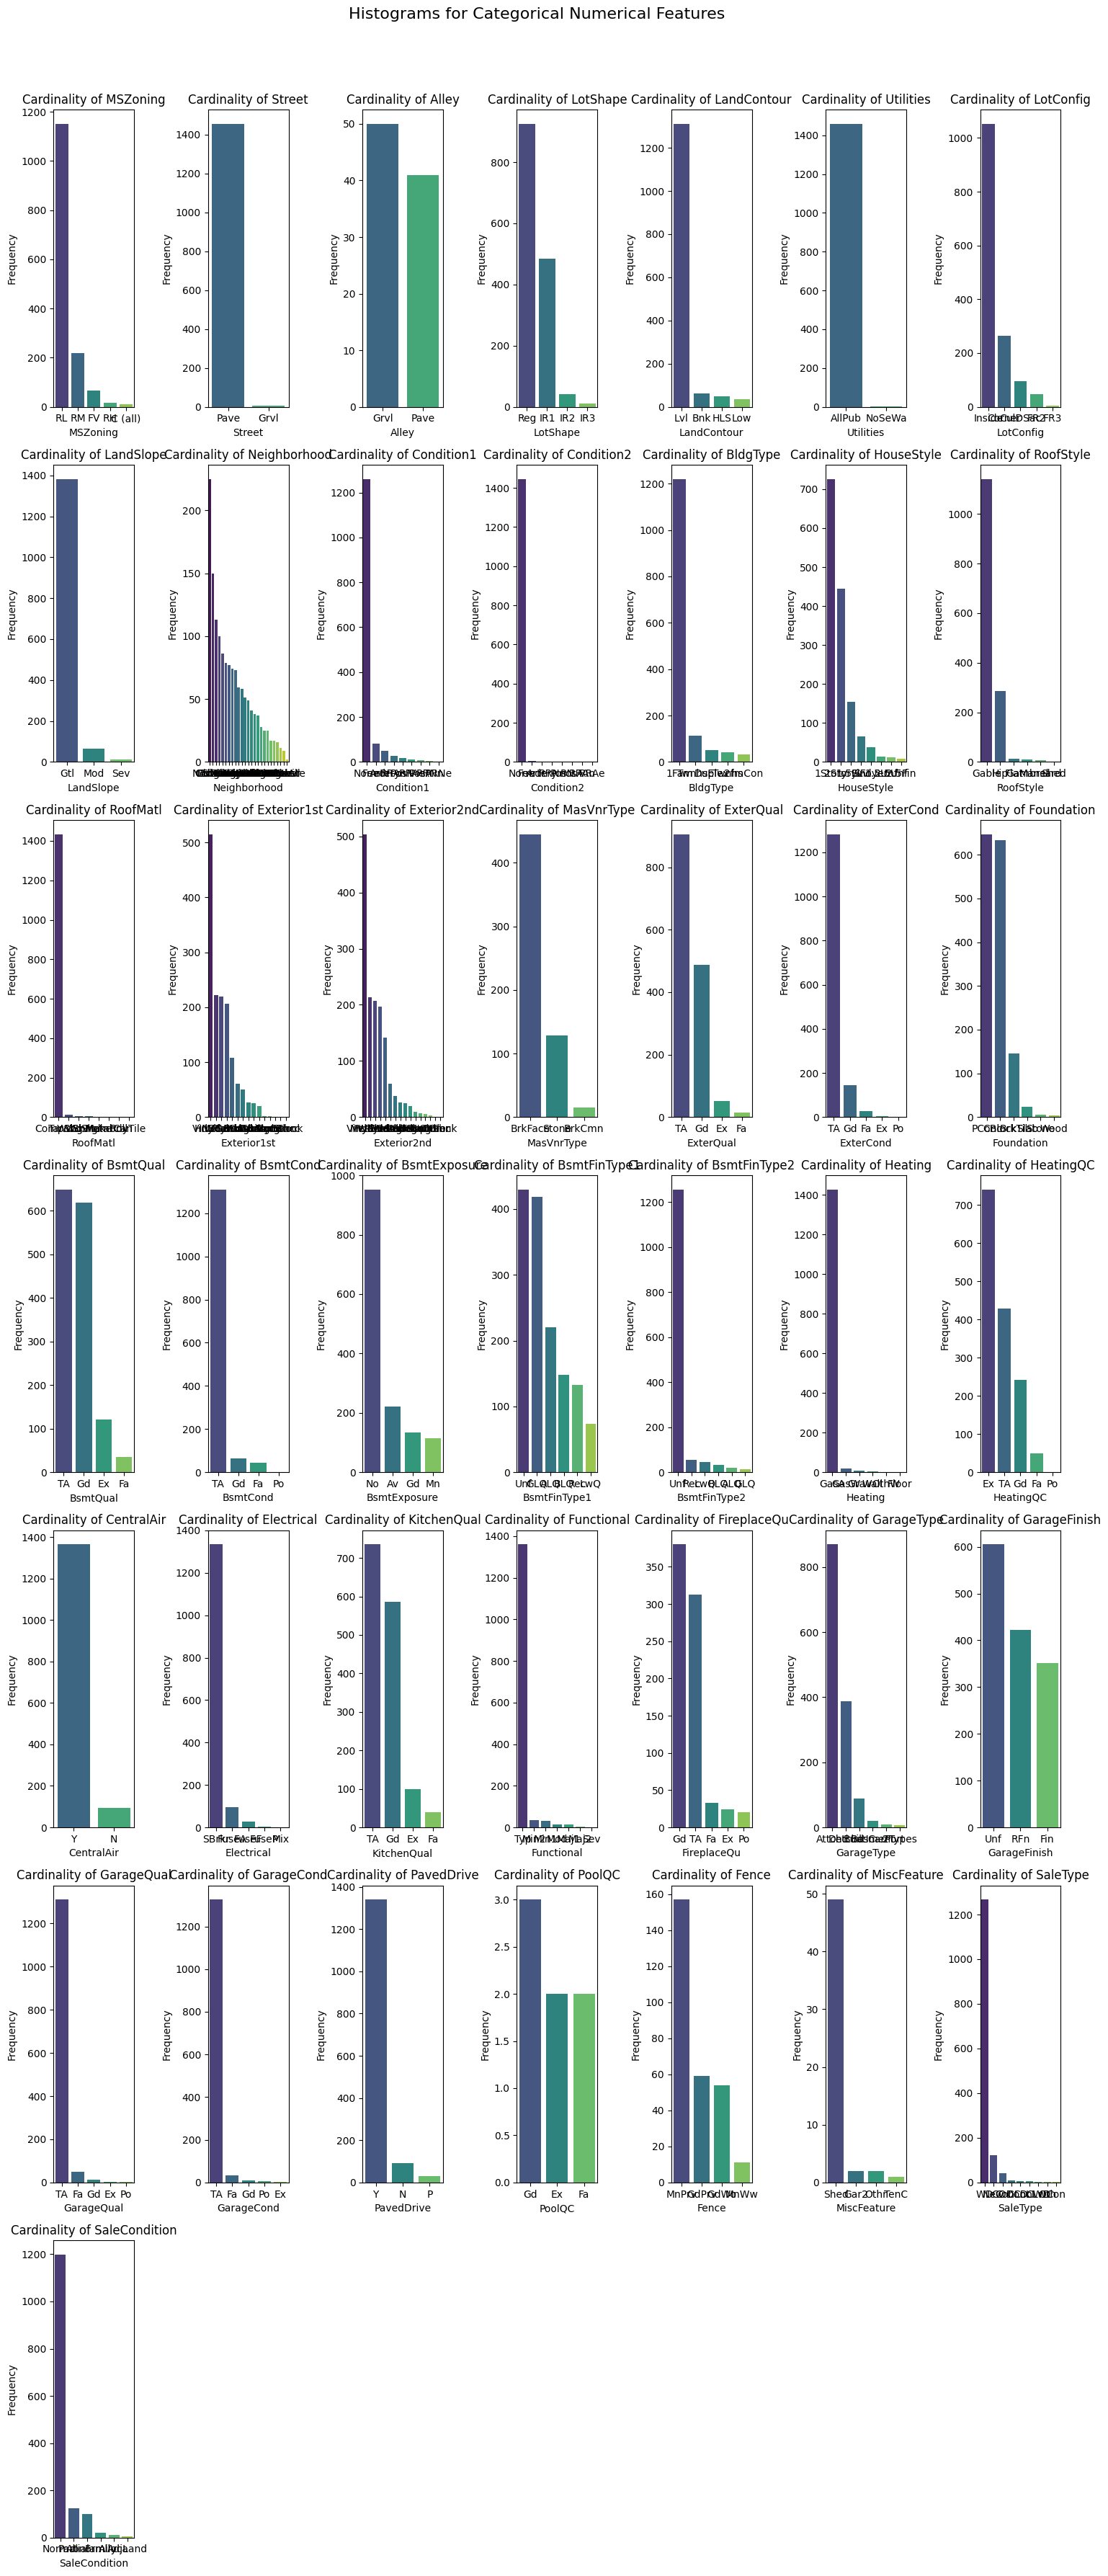

In [96]:
categorical_feature_cardinality_subplot(categorical_features,7)

#### Correlation matrix with comtinous numerical columns

In [124]:
def correlation_matrix(list_of_features):
    target=["SalePrice"]
    correlation_matrix=df_train[list_of_features+target].corr()
    plt.figure(figsize=(16,12))
    sns.heatmap(correlation_matrix,
                annot=True,              # Display the correlation value on the plot
                fmt=".2f",               # Format the values to two decimal places
                mask=np.triu(correlation_matrix),
                cmap='coolwarm',         # Set the color palette (e.g., coolwarm, vlag, viridis)
                #linewidths=0.5,          # Add lines between cells for clarity
                #linecolor='black',
                cbar=True)
    plt.title('Correlation Matrix Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()

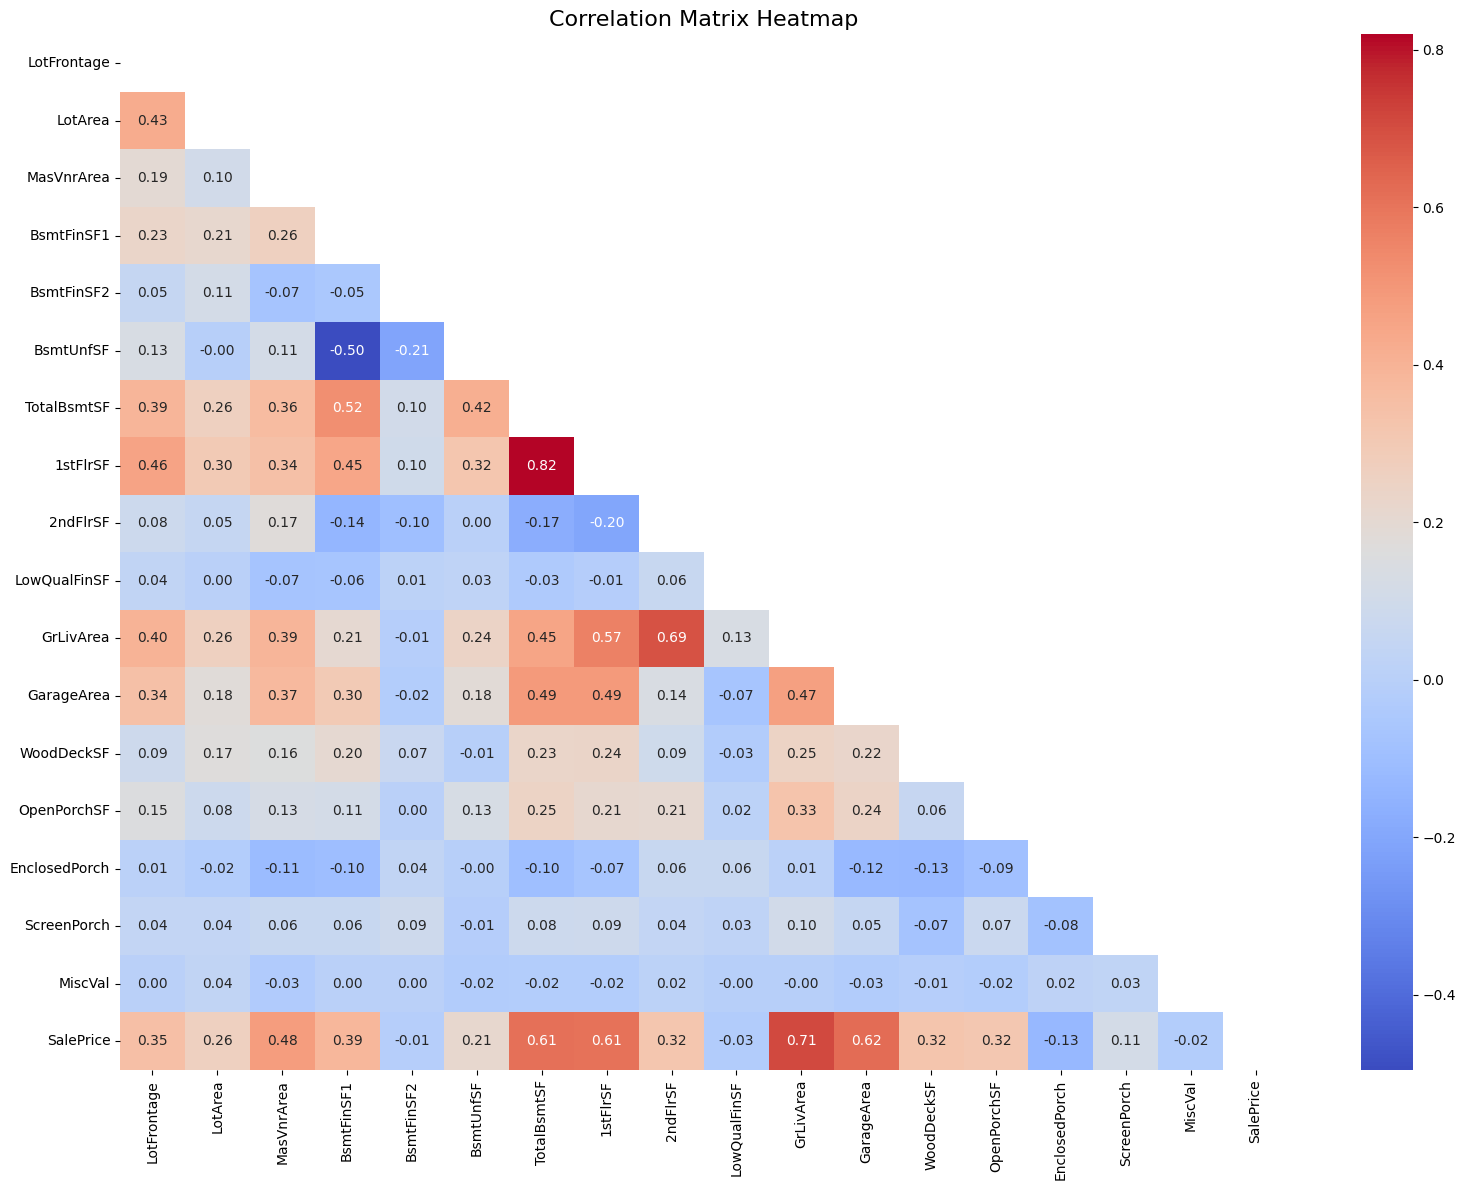

In [125]:
correlation_matrix(continous_num_features)